# Интересная кластеризация

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

Загрузим датасет, состоящий из картинок 1800 цифр, каждая картинка черно-белая размерностью 8 на 8. 

In [3]:
digits = datasets.load_digits()
print ("Датасет размера: ", digits.data.shape)
data = digits.data
y = digits.target

Датасет размера:  (1797, 64)


Посмотрим, как выглядят данные

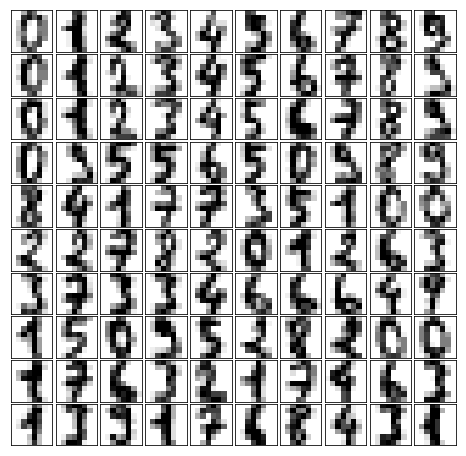

In [4]:
# code from https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
    plt.show()
        
plot_digits(digits.data)

Кажется что человек легко справится с классификацией! А что на счет ML?

Обучите модель логистической регрессии, посчитайте точность классификации. Как Вы думаете, по каким признака модель отличает цифры?

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.9, random_state=241)

In [6]:
# Обучите логистическую регрессию

In [7]:
# Считаем точность
preds_test = [0] * len(y_test)
print ("Accuracy is " + str(accuracy_score(y_test, preds_test)))

Accuracy is 0.09456118665018541


Для анализа данных часто применяют методы снижения размерности, например, метод главных компонент. Он позволяет "сжать данные" до меньше размерности. Данные размерности 2 уже можно легко визуализировать. 

Снизим размерность данных. Провизуализируем цветом таргет. Видны ли кластера?

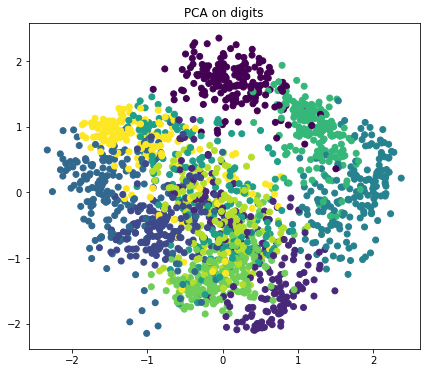

In [6]:
scaler = StandardScaler()
pca_scaler = PCA(n_components=2, random_state=140)
data_pca = scaler.fit_transform(pca_scaler.fit_transform(data))
plt.figure(figsize=(7, 6))
plt.title('PCA on digits')
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=y)
plt.show()

#  Классификация кластеризацией

Мы видим, что данные все-таки группируются. Давайте построим  кластера и посмотрим, будут ли кластера как-то сооноситься с цифрами?

Обучим модель смеси распределений на 10 компонент.  Будем использовать двухмерный сжатый датасет, который получен с помощью PCA.

In [7]:
new_gmm = GaussianMixture(n_components=10, random_state=0).fit(data_pca)

Аналогично разобьем на трейн и тест, но только по сжатым данным

In [8]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(data_pca, y, test_size=0.9, random_state=241)

Будем делать классификацию самым наивным образом: кластеризуем данные, дальше все кластера "проименуем" -- каждому кластеру придадим определенную метку класса. Метку будем выбирать по принципу большинства -- какого класса больше всего в кластер попало, такую метку и выдаем. На этапе предсказания для тестового объекта сначала предсказываем номер кластера, а по номеру кластера уже метку. 

In [9]:
def get_predicts_for_clusters(clusters,  labels):
    """
    Функция каждому кластеру присваивает метку, например, по принципу 
    большинства.
    clusters -- список размера N каждый элемент номер кластера из трейна
    labels   -- список размера N каждый элемент метка объекта  из трейна
    return   -- словарь {кластер : метка для данного кластера} 
    """
    cluster_predicts = {}
    for new_cluster in set(clusters):
        cluster_data = clusters[clusters == new_cluster]
        labels_data =  labels[clusters == new_cluster]
        best_label = None
        best_count = -1
        for new_label in set(labels):
            new_count = sum( labels_data == new_label )
            if new_count > best_count:
                best_count = new_count
                best_label = new_label
        cluster_predicts[new_cluster] = best_label
    return cluster_predicts


def get_predicts_on_test(clusters, cluster_2_pred):
    """
    Функция выдает предсказания по списку кластеров
    и выходу функции get_predicts_for_clusters
    clusters      -- список размера N каждый элемент номер кластера из теста
    cluster_pred  -- словарь {кластер : метка для данного кластера} 
    return        -- список размера N каждый элемент предсказанная метка из теста
    """
    return np.array([cluster_2_pred[i] if i in cluster_2_pred else 0 for i in clusters])

In [ ]:
# Проименовываем кластера
cluster_2_pred = get_predicts_for_clusters(new_gmm.predict(X_train_pca), y_train_pca)
# Делаем предсказание на тесте
preds_test = get_predicts_on_test(new_gmm.predict(X_test_pca), cluster_2_pred) 
# Считаем точность
print ("Accuracy is " + str(accuracy_score(y_test_pca, preds_test)))

Должно получиться качество значительно выше рандома (0.1), но хуже, чем у логистической регрессией.
Давайте теперь проанализиурем кластера. 

А что будет, если обучать на всех 64 признаках без сжатия?

In [13]:
new_gmm = GaussianMixture(n_components=10, random_state=0).fit(data)

In [ ]:
cluster_2_pred = get_predicts_for_clusters(new_gmm.predict(X_train), y_train)
preds_test = get_predicts_on_test(new_gmm.predict(X_test), cluster_2_pred) 
print ("Accuracy is " + str(accuracy_score(y_test, preds_test)))

Как Вы думаете, почему так получилось?

Отрисуйте несколько объектов из каждого из 10 кластеров и выведите метку, которые соответствуют данному кластеру. Вы видите какие-то закономерности в рамках одного кластера?
Какие кластера оказались самыми "грязными", то есть в каких кластерах много различных цифр? Похожи ли эти цифры по написанию?

In [197]:
# Проанализируйте кластера, можете использовать функцию plot_digits
# Самый простой вариант в цикле делать по i что-то такое
#    plt.subplot(5, 5, i+1)
#    plt.imshow(X[i].reshape(8, 8), cmap=plt.cm.Greys_r)
#    plt.title("Cluster bla bla bla", y[i])
#    plt.axis('off')

Задание для спортсменов -- давайте выбьем лучший скор на тесте!

1) Подберите число компонент, чтобы максимизировать скор на тесте. Как Вы думаете, почему качество так зависит от числа компонент смеси? Если останутся силы, можете посмотреть другие компоненты. Попробуйте нормализовать данные перед обучение GMM. Если останутся силы, попробуйте kmeans вместо GMM.

2) Соединим классификацию и кластеризацию. Добавим в X_train и в X_test для лог регрессии как признаки вероятности кластеров, которые выдает GMM (метод predict_proba).  Удалось улучшить качество первоначальной логистической регрессии?

In [195]:
# Выбейте супер скор, пожалуйста ^_^

## GMM - генерирует цифры!


Смесь нормальных распределений -- генеративная модель. То есть она моделирует p(X). Зная p(X), можно легко генерировать новые объекты. 

Обучите GMM  на всех данных, затем воспользуйтесь методом sample в классе GaussianMixture. Изобразите эти цифры. Какие проблемы сгенерированных цифр Вы видите? Попробуйте подобрать параметры GMM, чтобы цифры получались, как можно более правдоподбными. 

In [81]:
# Обучите GMM
# Вот так генерировать новые объекты по обученному GMM
# data_new = gmm.sample(100)

#plot_digits(data_new)
#plt.show()

Кажется, что цифры это просто? Как насчет людей?

https://medium.com/coinmonks/celebrity-face-generation-using-gans-tensorflow-implementation-eaa2001eef86 (смотреть только картинки, код и формулы пропускать!)